<a href="https://colab.research.google.com/github/AltagiAbdallah/airline-ops-sentiment-analysis/blob/main/Leveraging_Predictive_Analytics_and_NLP_Modelling_to_Enhance_Airline_Operations_and_Customer_Loyalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leveraging Sentiment Analysis to Enhance Airline Customer Loyalty

**Goal:** Use Twitter airline data to:
- Clean and explore passenger tweets
- Build sentiment classifiers
- Discover complaint patterns (Market Basket Analysis)
- Detect abnormal/critical tweets
- Provide loyalty-oriented recommendations for airlines


**1. Imports & configuration**

 >>  Library Imports and Environment Configuration

The required Python libraries are imported to support data manipulation, visualisation, natural language processing, and machine learning.  
Warnings are suppressed to keep the notebook output clean and focused on the analysis steps.

In [ ]:
# Core
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Market Basket Analysis
!pip install -q mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import PCA

**2. Load data**

>>  Data Access and Loading

Google Drive is mounted to access the project files stored in the cloud environment.  
The Twitter US Airline Sentiment dataset is then loaded into a pandas DataFrame for further cleaning and analysis.


In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/Data science projects /DS/Airline_Loyalty_Project/Datasets /Tweets.csv')

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_g

**3. Data cleaning function**

>> Data Cleaning and Preparation

A dedicated cleaning function is defined to prepare the Twitter dataset for analysis.  
The procedure includes selecting relevant columns, handling missing values, removing duplicate tweets, and converting variables to appropriate data types.  
This step ensures that the data is consistent and suitable for subsequent modelling and visualisation.


In [ ]:
def clean_twitter_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean Twitter US Airline Sentiment dataset:
    - drop unused columns
    - handle missing values
    - fix obvious errors
    - standardise types
    """
    df = df.copy()

    # Keep only columns you really use
    keep_cols = [
        "airline",
        "airline_sentiment",
        "airline_sentiment_confidence",
        "negativereason",
        "negativereason_confidence",
        "text",
        "tweet_created"
    ]
    df = df[keep_cols]

    # Basic NA handling
    df["negativereason"] = df["negativereason"].fillna("Unknown")
    df["negativereason_confidence"] = df["negativereason_confidence"].fillna(0.0)

    # Drop perfect duplicates
    df = df.drop_duplicates(subset=["text", "tweet_created"])

    # Convert to appropriate types
    df["tweet_created"] = pd.to_datetime(df["tweet_created"])
    df["airline"] = df["airline"].astype("category")
    df["airline_sentiment"] = df["airline_sentiment"].astype("category")

    return df

df = clean_twitter_data(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 14485 entries, 0 to 14639
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype                    
---  ------                        --------------  -----                    
 0   airline                       14485 non-null  category                 
 1   airline_sentiment             14485 non-null  category                 
 2   airline_sentiment_confidence  14485 non-null  float64                  
 3   negativereason                14485 non-null  object                   
 4   negativereason_confidence     14485 non-null  float64                  
 5   text                          14485 non-null  object                   
 6   tweet_created                 14485 non-null  datetime64[ns, UTC-08:00]
dtypes: category(2), datetime64[ns, UTC-08:00](1), float64(2), object(2)
memory usage: 707.6+ KB


**4. EDA**

>> Exploratory Visualisation of Sentiment

Two exploratory visualisations are created to understand the overall sentiment structure in the dataset.  
The first plot shows the distribution of sentiment classes, while the second compares sentiment across different airlines.  
These plots provide an initial view of customer perception and potential areas of concern for each carrier.


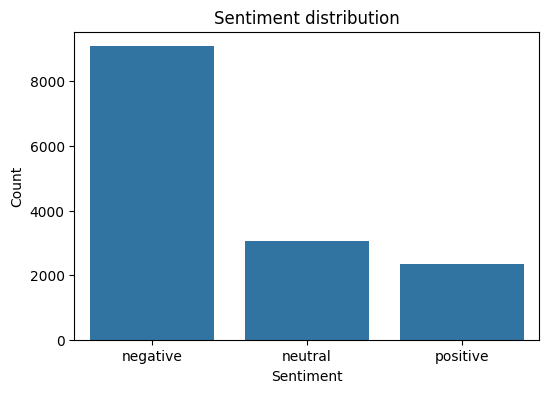

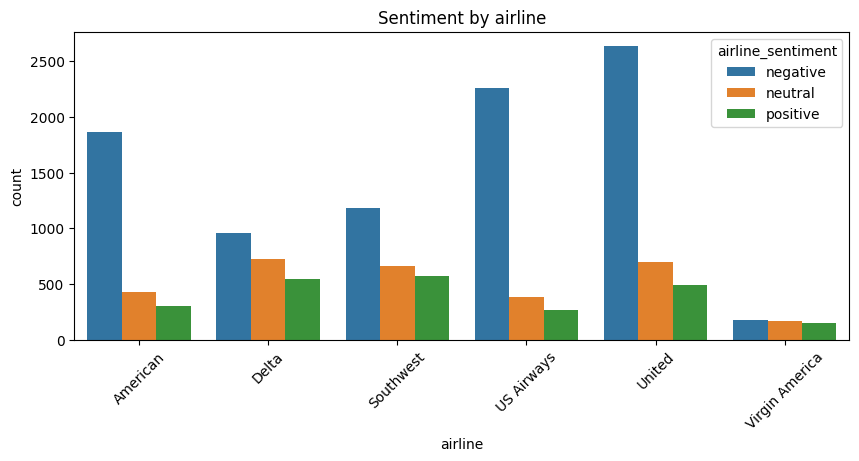

In [ ]:
def plot_sentiment_distribution(df):
    fig, ax = plt.subplots(figsize=(6,4))
    sns.countplot(x="airline_sentiment", data=df, ax=ax)
    ax.set_title("Sentiment distribution")
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Count")
    plt.show()

def plot_sentiment_by_airline(df):
    fig, ax = plt.subplots(figsize=(10,4))
    sns.countplot(x="airline", hue="airline_sentiment", data=df, ax=ax)
    ax.set_title("Sentiment by airline")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

plot_sentiment_distribution(df)
plot_sentiment_by_airline(df)


## 5. Text preprocessing + models

**5.1 Text preprocessing (TF–IDF)**

Tweets are transformed into numerical TF-IDF features to prepare them for machine learning models.

In [ ]:
# Use the 'text' column as input
texts = df['text'].astype(str)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=20000,      # you can adjust this
    ngram_range=(1, 2)       # unigrams + bigrams
)

# Fit on the full corpus and transform into TF-IDF matrix
X_tfidf = vectorizer.fit_transform(texts)

print("TF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (14485, 20000)


**5.2 Train–test split**

The dataset is split into training and testing subsets using an 80/20 ratio with stratified sampling.


In [ ]:
# Target variable
y = df['airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (11588, 20000)
Shape of X_test: (2897, 20000)
Shape of y_train: (11588,)
Shape of y_test: (2897,)


5.3 Build and train classification models

Four classification models are trained on the TF-IDF features to predict tweet sentiment.


In [ ]:
# Initialize the models
model_lr = LogisticRegression(max_iter=200, random_state=42)
model_dt = DecisionTreeClassifier(random_state=42)
model_rf = RandomForestClassifier(n_estimators=300, random_state=42)
model_nb = MultinomialNB()

# Train the models
model_lr.fit(X_train, y_train)
model_dt.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_nb.fit(X_train, y_train)

print("All four models have been trained.")


All four models have been trained.


5.4 Evaluate models


Each model is evaluated using accuracy, precision, recall, and F1-score on the test set.


In [ ]:

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, y_pred))
    return acc

acc_lr = evaluate_model("Logistic Regression", model_lr, X_test, y_test)
acc_dt = evaluate_model("Decision Tree", model_dt, X_test, y_test)
acc_rf = evaluate_model("Random Forest", model_rf, X_test, y_test)
acc_nb = evaluate_model("Multinomial Naive Bayes", model_nb, X_test, y_test)



=== Logistic Regression ===
Accuracy: 0.7746
              precision    recall  f1-score   support

    negative       0.79      0.95      0.86      1816
     neutral       0.66      0.43      0.52       614
    positive       0.83      0.54      0.66       467

    accuracy                           0.77      2897
   macro avg       0.76      0.64      0.68      2897
weighted avg       0.77      0.77      0.76      2897


=== Decision Tree ===
Accuracy: 0.6545
              precision    recall  f1-score   support

    negative       0.76      0.79      0.77      1816
     neutral       0.39      0.36      0.37       614
    positive       0.56      0.51      0.53       467

    accuracy                           0.65      2897
   macro avg       0.57      0.55      0.56      2897
weighted avg       0.65      0.65      0.65      2897


=== Random Forest ===
Accuracy: 0.7473
              precision    recall  f1-score   support

    negative       0.76      0.95      0.85      1816
   

5.5 Compare model performance

A bar chart is produced to compare the accuracy of all trained models.


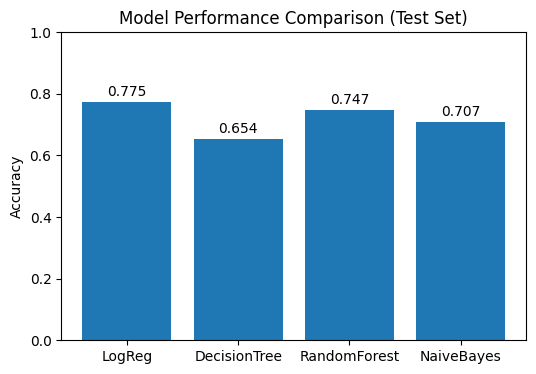

In [ ]:

model_names = ["LogReg", "DecisionTree", "RandomForest", "NaiveBayes"]
accuracies = [acc_lr, acc_dt, acc_rf, acc_nb]

plt.figure(figsize=(6,4))
bars = plt.bar(model_names, accuracies)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison (Test Set)")

# Add value labels on top of bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{acc:.3f}", ha='center', va='bottom')

plt.show()


5.6 Select best model

The highest-performing model is selected for use in downstream sentiment analysis tasks.


In [ ]:
# Choose the best model based on accuracy (adjust if another model wins)
model_accuracies = {
    "Logistic Regression": acc_lr,
    "Decision Tree": acc_dt,
    "Random Forest": acc_rf,
    "Naive Bayes": acc_nb
}

model_accuracies


{'Logistic Regression': 0.7745944080082844,
 'Decision Tree': 0.6544701415257163,
 'Random Forest': 0.7473248187780462,
 'Naive Bayes': 0.7072833966171902}

In [ ]:
best_model = model_lr
best_model_name = "Logistic Regression"

print("Selected best model:", best_model_name)

Selected best model: Logistic Regression


## 6. Market Basket Analysis (MBA) on sentiment × complaint reason



Market Basket Analysis is used to discover frequent combinations of airlines, sentiments, and complaint reasons.


In [ ]:
# Create a smaller DataFrame for MBA
mba_df = df[["airline", "airline_sentiment", "negativereason"]].copy()

# Combine fields into a transaction-style string
mba_df["transaction"] = (
    mba_df["airline"].astype(str)
    + "|" + mba_df["airline_sentiment"].astype(str)
    + "|" + mba_df["negativereason"].astype(str)
)

# One-hot encoding of items in each transaction
basket = mba_df["transaction"].str.get_dummies(sep="|")

print("Basket shape:", basket.shape)
basket.head()


Basket shape: (14485, 20)


,American,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Delta,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,Southwest,US Airways,United,Unknown,Virgin America,longlines,negative,neutral,positive
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
# Generate frequent itemsets
freq_items = apriori(basket, min_support=0.02, use_colnames=True)

print("Number of frequent itemsets:", len(freq_items))
freq_items.head()


Number of frequent itemsets: 71


,support,itemsets
0,0.179772,(American)
1,0.039696,(Bad Flight)
2,0.081187,(Can't Tell)
3,0.057232,(Cancelled Flight)
4,0.199172,(Customer Service Issue)


In [ ]:
# Generate association rules
rules = association_rules(freq_items, metric="lift", min_threshold=1.0)
rules = rules.sort_values("confidence", ascending=False)

rules.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
15,(Customer Service Issue),(negative),0.199172,0.626993,0.199172,1.0,1.594913,1.0,0.074292,inf,0.465776,0.317661,1.0,0.658831
11,(Cancelled Flight),(negative),0.057232,0.626993,0.057232,1.0,1.594913,1.0,0.021348,inf,0.395650,0.091279,1.0,0.545640
9,(Can't Tell),(negative),0.081187,0.626993,0.081187,1.0,1.594913,1.0,0.030283,inf,0.405966,0.129487,1.0,0.564743
4,(Bad Flight),(negative),0.039696,0.626993,0.039696,1.0,1.594913,1.0,0.014807,inf,0.388426,0.063312,1.0,0.531656
102,"(Late Flight, United)",(negative),0.036244,0.626993,0.036244,1.0,1.594913,1.0,0.013519,inf,0.387034,0.057807,1.0,0.528903
108,"(neutral, Southwest)",(Unknown),0.045841,0.373007,0.045841,1.0,2.680918,1.0,0.028742,inf,0.657116,0.122895,1.0,0.561447
96,"(Late Flight, US Airways)",(negative),0.031274,0.626993,0.031274,1.0,1.594913,1.0,0.011665,inf,0.385048,0.049879,1.0,0.524939
90,"(Delta, positive)",(Unknown),0.037556,0.373007,0.037556,1.0,2.680918,1.0,0.023547,inf,0.651460,0.100685,1.0,0.550342
30,(Late Flight),(negative),0.113911,0.626993,0.113911,1.0,1.594913,1.0,0.042490,inf,0.420958,0.181678,1.0,0.590839
33,(Lost Luggage),(negative),0.049638,0.626993,0.049638,1.0,1.594913,1.0,0.018515,inf,0.392489,0.079168,1.0,0.539584


In [ ]:
# Filter rules where consequents contain 'negative'
neg_rules = rules[rules["consequents"].astype(str).str.contains("negative")]
neg_rules.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
15,(Customer Service Issue),(negative),0.199172,0.626993,0.199172,1.0,1.594913,1.0,0.074292,inf,0.465776,0.317661,1.0,0.658831
11,(Cancelled Flight),(negative),0.057232,0.626993,0.057232,1.0,1.594913,1.0,0.021348,inf,0.395650,0.091279,1.0,0.545640
9,(Can't Tell),(negative),0.081187,0.626993,0.081187,1.0,1.594913,1.0,0.030283,inf,0.405966,0.129487,1.0,0.564743
4,(Bad Flight),(negative),0.039696,0.626993,0.039696,1.0,1.594913,1.0,0.014807,inf,0.388426,0.063312,1.0,0.531656
102,"(Late Flight, United)",(negative),0.036244,0.626993,0.036244,1.0,1.594913,1.0,0.013519,inf,0.387034,0.057807,1.0,0.528903
96,"(Late Flight, US Airways)",(negative),0.031274,0.626993,0.031274,1.0,1.594913,1.0,0.011665,inf,0.385048,0.049879,1.0,0.524939
30,(Late Flight),(negative),0.113911,0.626993,0.113911,1.0,1.594913,1.0,0.042490,inf,0.420958,0.181678,1.0,0.590839
33,(Lost Luggage),(negative),0.049638,0.626993,0.049638,1.0,1.594913,1.0,0.018515,inf,0.392489,0.079168,1.0,0.539584
25,(Flight Booking Problems),(negative),0.036106,0.626993,0.036106,1.0,1.594913,1.0,0.013468,inf,0.386979,0.057586,1.0,0.528793
23,(Flight Attendant Complaints),(negative),0.032793,0.626993,0.032793,1.0,1.594913,1.0,0.012232,inf,0.385653,0.052301,1.0,0.526151


## 7. Clustering tweets

Tweets are clustered using TF-IDF features and K-Means to reveal groups of similar sentiment patterns.


In [ ]:
# TF-IDF for clustering (can be smaller feature space)
tfidf_clust = TfidfVectorizer(max_features=5000, stop_words='english')

X_tfidf_clust = tfidf_clust.fit_transform(df["text"].astype(str))

print("TF-IDF matrix for clustering:", X_tfidf_clust.shape)


TF-IDF matrix for clustering: (14485, 5000)


In [ ]:
# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_tfidf_clust)

df["cluster"] = clusters
df["cluster"].value_counts()


,count
cluster,
0,8399
2,3866
1,2220


In [ ]:
# Check sentiment composition per cluster
cluster_sentiment = (
    df.groupby("cluster")["airline_sentiment"]
      .value_counts(normalize=True)
      .rename("proportion")
      .reset_index()
)

cluster_sentiment


,cluster,airline_sentiment,proportion
0,0,negative,0.649839
1,0,neutral,0.195976
2,0,positive,0.154185
3,1,negative,0.428378
4,1,neutral,0.327027
5,1,positive,0.244595
6,2,negative,0.691412
7,2,neutral,0.180290
8,2,positive,0.128298


***PCA 2D visualisation***

A 2D PCA plot is used to visualise tweet clusters in a reduced feature space.


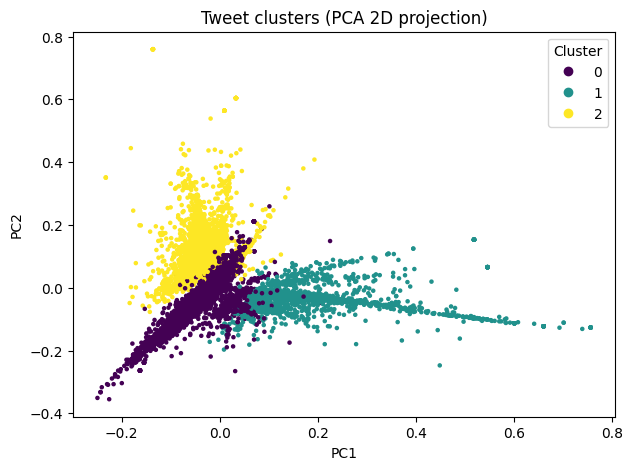

In [ ]:
# Reduce dimensionality for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf_clust.toarray())

plt.figure(figsize=(7,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, s=5)
plt.title("Tweet clusters (PCA 2D projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


## 8. Anomaly detection on “critical” tweets

An isolation forest model is applied to detect anomalous tweets that may correspond to extreme or unusual feedback.


In [ ]:
# Use confidence scores as anomaly features
features = df[["airline_sentiment_confidence", "negativereason_confidence"]].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

iso = IsolationForest(
    n_estimators=200,
    contamination=0.02,
    random_state=42
)
df["anomaly_score"] = iso.fit_predict(X_scaled)

# -1 = anomaly, 1 = normal
anomalies = df[df["anomaly_score"] == -1]
print("Number of anomalies:", len(anomalies))
anomalies.head()


Number of anomalies: 286


,airline,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,text,tweet_created,cluster,anomaly_score
1,Virgin America,positive,0.3486,Unknown,0.0000,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,0,-1
114,Virgin America,positive,0.3482,Unknown,0.0000,@VirginAmerica come back to #PHL already. We n...,2015-02-23 06:07:54-08:00,0,-1
142,Virgin America,neutral,0.3550,Unknown,0.0000,@VirginAmerica Can you find us a flt out of LA...,2015-02-22 13:49:59-08:00,0,-1
183,Virgin America,positive,0.3579,Unknown,0.0000,😎 RT @VirginAmerica: You’ve met your match. Go...,2015-02-21 18:09:54-08:00,0,-1
197,Virgin America,negative,0.7158,Cancelled Flight,0.7158,@VirginAmerica You have any flights flying int...,2015-02-21 15:27:52-08:00,0,-1


***2D plot of normal vs anomalous tweets***

A scatter plot highlights the difference between normal and anomalous tweets in the confidence feature space.


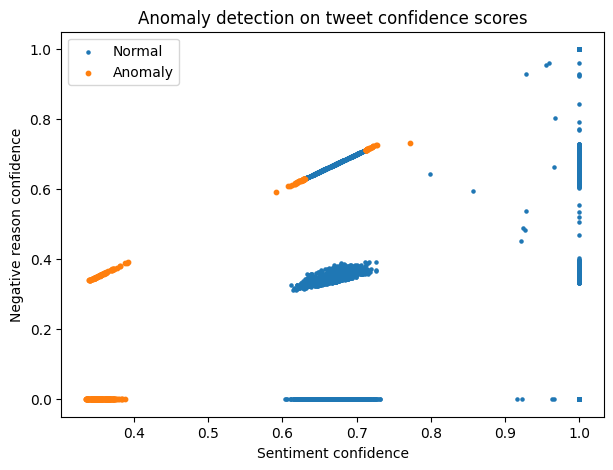

In [ ]:
normal = df[df["anomaly_score"] == 1]
abnormal = df[df["anomaly_score"] == -1]

plt.figure(figsize=(7,5))
plt.scatter(
    normal["airline_sentiment_confidence"],
    normal["negativereason_confidence"],
    s=5,
    label="Normal"
)
plt.scatter(
    abnormal["airline_sentiment_confidence"],
    abnormal["negativereason_confidence"],
    s=10,
    label="Anomaly"
)
plt.xlabel("Sentiment confidence")
plt.ylabel("Negative reason confidence")
plt.title("Anomaly detection on tweet confidence scores")
plt.legend()
plt.show()


***Airlines with most anomalies***

Anomaly counts are aggregated by airline to identify carriers with the highest concentration of critical tweets.


In [ ]:
airline_anomalies = (
    df[df["anomaly_score"] == -1]
      .groupby("airline")["anomaly_score"]
      .count()
      .sort_values(ascending=False)
      .rename("n_anomalies")
)

airline_anomalies


,n_anomalies
airline,
United,76
Delta,60
Southwest,55
US Airways,46
American,37
Virgin America,12


##  9. Simple loyalty-oriented recommender

9.1 Airline loyalty summary

Airlines are ranked by the proportion of positive tweets to estimate customer loyalty levels.


In [ ]:
def airline_loyalty_summary(df):
    summary = (
        df.groupby("airline")["airline_sentiment"]
          .value_counts(normalize=True)
          .rename("proportion")
          .reset_index()
          .pivot(index="airline", columns="airline_sentiment", values="proportion")
          .fillna(0)
    )
    # Ensure all sentiment columns exist
    for col in ["negative", "neutral", "positive"]:
        if col not in summary.columns:
            summary[col] = 0.0

    summary = summary.sort_values("positive", ascending=False)
    # Clear the name of the columns index to avoid potential conflicts during join
    summary.columns.name = None
    # Convert the index to string type for compatibility during join operations
    summary.index = summary.index.astype(str)
    return summary

loyalty_summary = airline_loyalty_summary(df)
loyalty_summary

,negative,neutral,positive
airline,,,
Virgin America,0.359127,0.339286,0.301587
Delta,0.429793,0.325383,0.244824
Southwest,0.490083,0.274380,0.235537
United,0.688906,0.182365,0.128728
American,0.715822,0.166283,0.117896
US Airways,0.776862,0.130793,0.092345


9.2 Recommend top-k airlines

A simple recommender selects the airlines with the highest share of positive sentiment.


In [ ]:
def recommend_airlines_top_k(loyalty_df, k=3):
    return loyalty_df.sort_values("positive", ascending=False).head(k)

top_5_airlines = recommend_airlines_top_k(loyalty_summary, k=5)
top_5_airlines


,negative,neutral,positive
airline,,,
Virgin America,0.359127,0.339286,0.301587
Delta,0.429793,0.325383,0.244824
Southwest,0.490083,0.274380,0.235537
United,0.688906,0.182365,0.128728
American,0.715822,0.166283,0.117896


## 10. Conclusion

The sentiment analysis of airline-related tweets provides meaningful insights into customer perceptions and loyalty tendencies. By applying TF-IDF vectorisation and evaluating multiple machine learning models, the analysis identifies the most effective classifier for understanding passenger sentiment. Logistic Regression demonstrated the strongest overall performance and was selected as the primary model for downstream tasks.

Market Basket Analysis revealed frequent combinations of airlines, negative reasons, and sentiment patterns, helping to highlight the most common sources of customer dissatisfaction. Clustering further uncovered underlying groupings of tweets with similar sentiment structures, while anomaly detection identified unusually negative or high-impact feedback that may require special attention.

Finally, a simple loyalty-oriented recommender was developed by ranking airlines based on the proportion of positive sentiment. Airlines with consistently higher positive sentiment and fewer detected anomalies are more likely to retain loyal customers and provide a stable service experience.

Overall, this analysis demonstrates how text mining, machine learning, and pattern-discovery techniques can be used to monitor customer sentiment, detect issues early, and support data-driven airline loyalty strategies.




---


### Leveraging Predictive Analytics to Understand and Forecast Airline Delays
### Flight Delay Predictive Modelling & Operational Insights

**1. Library Imports and Setup**

The required Python libraries are imported to support data loading, feature engineering, visualization, machine learning, anomaly detection, and time-series forecasting.


In [ ]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and math libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Time-series forecasting library
import statsmodels.api as sm


**2. Load Dataset**

>> Data Loading

The flight delay dataset is loaded from Google Drive. This dataset contains three months of U.S. domestic airline operations, including schedule details, delay times, and carrier information.


In [ ]:
# Mount Google Drive to access dataset from cloud storage
from google.colab import drive
drive.mount('/content/drive')

# Load flight delay dataset
df = pd.read_csv('/content/drive/MyDrive/Data science projects /DS/Airline_Loyalty_Project/Datasets /flights_sample_3m.csv')
df.head()


Mounted at /content/drive


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


**3. Data Cleaning**

The dataset is cleaned by handling missing values, converting date formats, and engineering a binary delay label. This prepares the data for classification and predictive modelling tasks.

In [ ]:
def clean_flights(df):
    """
    Clean and prepare flight delay dataset for analysis:
    - Convert date formats
    - Create a binary delay flag
    - Remove missing delay-related records
    - Convert key columns to categoricals
    """
    df = df.copy()

    # Convert flight date column to datetime format
    df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

    # Create target variable: 1 = delayed, 0 = on-time (15-minute threshold)
    df["DELAYED"] = (df["ARR_DELAY"] > 15).astype(int)

    # Remove rows without delay information
    df = df.dropna(subset=["ARR_DELAY", "DEP_DELAY"])

    # Convert relevant columns to category type
    for col in ["OP_UNIQUE_CARRIER", "ORIGIN", "DEST"]:
        if col in df.columns:
            df[col] = df[col].astype("category")

    return df

# Apply cleaning function
df = clean_flights(df)

# Inspect cleaned dataset structure
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2913802 entries, 0 to 2999999
Data columns (total 33 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   FL_DATE                  datetime64[ns]
 1   AIRLINE                  object        
 2   AIRLINE_DOT              object        
 3   AIRLINE_CODE             object        
 4   DOT_CODE                 int64         
 5   FL_NUMBER                int64         
 6   ORIGIN                   category      
 7   ORIGIN_CITY              object        
 8   DEST                     category      
 9   DEST_CITY                object        
 10  CRS_DEP_TIME             int64         
 11  DEP_TIME                 float64       
 12  DEP_DELAY                float64       
 13  TAXI_OUT                 float64       
 14  WHEELS_OFF               float64       
 15  WHEELS_ON                float64       
 16  TAXI_IN                  float64       
 17  CRS_ARR_TIME             int64  

**4. Exploratory Data Analysis (EDA)**


Initial visualizations provide insights into the distribution of delayed flights and performance across airports and airlines.

>> Delay distribution

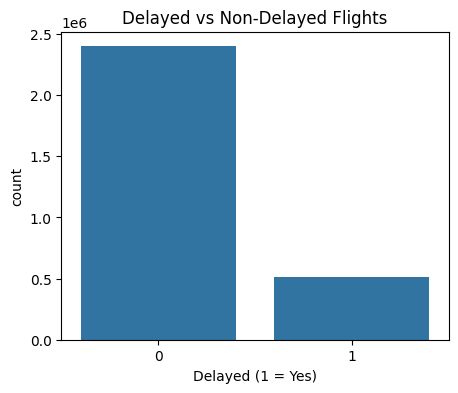

In [ ]:
# Plot distribution of delayed vs non-delayed flights

plt.figure(figsize=(5,4))
sns.countplot(x=df["DELAYED"])
plt.title("Delayed vs Non-Delayed Flights")
plt.xlabel("Delayed (1 = Yes)")
plt.show()


>> Delay rate by origin airport

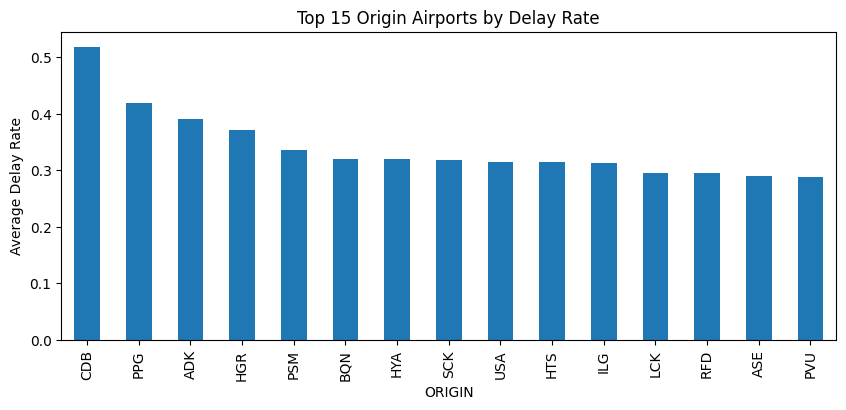

In [ ]:
# Compute delay rate for each origin airport
origin_delay = df.groupby("ORIGIN")["DELAYED"].mean().sort_values(ascending=False).head(15)

# Bar chart of top 15 airports with highest delay rate
plt.figure(figsize=(10,4))
origin_delay.plot(kind="bar")
plt.title("Top 15 Origin Airports by Delay Rate")
plt.ylabel("Average Delay Rate")
plt.show()


**5. Predictive Modelling: Classification**


A Random Forest classifier is trained to predict whether a flight will be delayed based on operational features such as departure delay, taxi-out time, and distance.

>> Prepare features

In [ ]:
# Select main predictive features
features = ["DEP_DELAY", "TAXI_OUT", "DISTANCE"]
X = df[features]

# Target variable: delayed vs not delayed
y = df["DELAYED"]


>> Train/test split

In [ ]:
# Split into train and test sets (80/20), stratified by delay rate
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


>> Feature Scaling

In [ ]:
# Standardize feature values for better model performance
scaler = StandardScaler()
X_trainScaled = scaler.fit_transform(X_train)
X_testScaled = scaler.transform(X_test)


>> Train Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=120,      # fewer trees
    max_depth=12,         # limit depth
    min_samples_leaf=50,  # avoid overfitting & reduce size
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf.fit(X_trainScaled, y_train)

y_pred = rf.predict(X_testScaled)
print(classification_report(y_test, y_pred))

Training Random Forest...
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    479703
           1       0.91      0.79      0.85    103058

    accuracy                           0.95    582761
   macro avg       0.93      0.89      0.91    582761
weighted avg       0.95      0.95      0.95    582761



>> Feature Importance

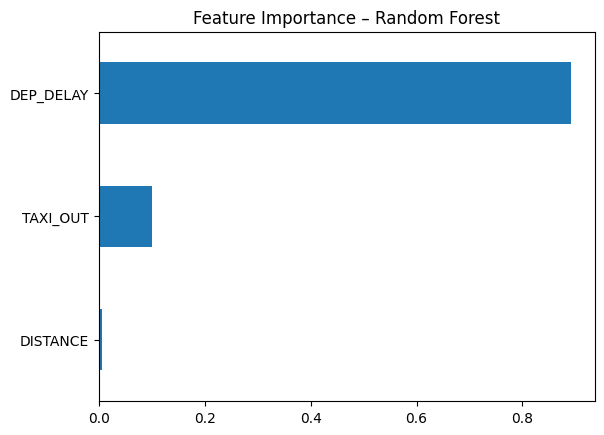

In [ ]:
# Plot feature importance to identify strongest predictors
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind="barh")
plt.title("Feature Importance – Random Forest")
plt.show()


**6. Anomaly Detection**

Isolation Forest is used to detect unusual or extreme delay events, identifying operational irregularities that may require deeper investigation.

In [ ]:
# Use arrival delay and distance as anomaly detection features
anomaly_features = df[["ARR_DELAY", "DISTANCE"]]

# Standardize features for anomaly detection
scaler2 = StandardScaler()
X_scaled = scaler2.fit_transform(anomaly_features)

# Initialize Isolation Forest model
iso = IsolationForest(contamination=0.01, random_state=42)

# Predict anomalies (-1 = anomaly, 1 = normal)
df["ANOMALY"] = iso.fit_predict(X_scaled)

# Display first few anomalies
anomalies = df[df["ANOMALY"] == -1]
anomalies.head()


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DELAYED,ANOMALY
29,2023-04-15,Republic Airline,Republic Airline: YX,YX,20452,3615,MSP,"Minneapolis, MN",EWR,"Newark, NJ",...,233.0,145.0,1008.0,0.0,0.0,1124.0,0.0,0.0,1,-1
115,2023-01-30,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,867,DFW,"Dallas/Fort Worth, TX",LAX,"Los Angeles, CA",...,265.0,176.0,1235.0,0.0,8.0,57.0,0.0,215.0,1,-1
188,2019-12-01,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,5063,RDU,"Raleigh/Durham, NC",LAS,"Las Vegas, NV",...,322.0,306.0,2026.0,0.0,0.0,7.0,0.0,333.0,1,-1
506,2019-03-15,Endeavor Air Inc.,Endeavor Air Inc.: 9E,9E,20363,3453,CVG,"Cincinnati, OH",LGA,"New York, NY",...,141.0,108.0,585.0,0.0,0.0,250.0,0.0,0.0,1,-1
553,2023-05-06,JetBlue Airways,JetBlue Airways: B6,B6,20409,400,MSY,"New Orleans, LA",BOS,"Boston, MA",...,207.0,184.0,1368.0,437.0,0.0,0.0,0.0,159.0,1,-1


>> Plot normal vs anomalous flights

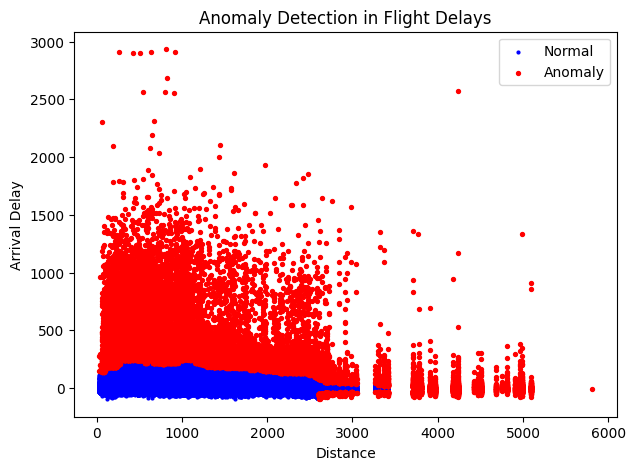

In [ ]:
# Plot normal vs anomalous flights
plt.figure(figsize=(7,5))
normal = df[df["ANOMALY"] == 1]

plt.scatter(normal["DISTANCE"], normal["ARR_DELAY"], s=4, c="blue", label="Normal")
plt.scatter(anomalies["DISTANCE"], anomalies["ARR_DELAY"], s=8, c="red", label="Anomaly")

plt.xlabel("Distance")
plt.ylabel("Arrival Delay")
plt.title("Anomaly Detection in Flight Delays")
plt.legend()
plt.show()


**7. Clustering Flights**


K-Means clustering groups flights based on operational characteristics, supporting segmentation of delay behavior.

In [ ]:
# Select features for clustering
clust_features = df[["DEP_DELAY", "ARR_DELAY", "DISTANCE"]].fillna(0)

# Standardize features
scaler3 = StandardScaler()
X_c = scaler3.fit_transform(clust_features)

# Initialize K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)

# Assign cluster labels
df["cluster"] = kmeans.fit_predict(X_c)

# View cluster counts
df["cluster"].value_counts()


,count
cluster,
0,2330479
2,507384
1,75939


>> PCA plot

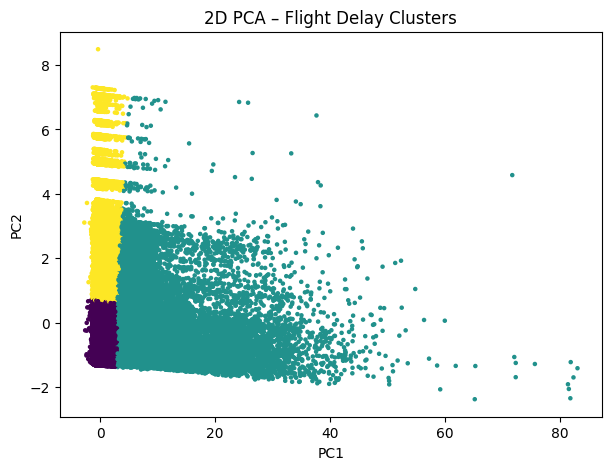

In [ ]:
# Reduce dimensionality to 2D for visualizing clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_c)

# Plot PCA-reduced cluster space
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], s=5)
plt.title("2D PCA – Flight Delay Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


**8. Time Series Forecasting (ARIMA)**


Monthly delay rates are computed and forecasted using ARIMA to predict future operational performance.

>>  Compute monthly delay rate

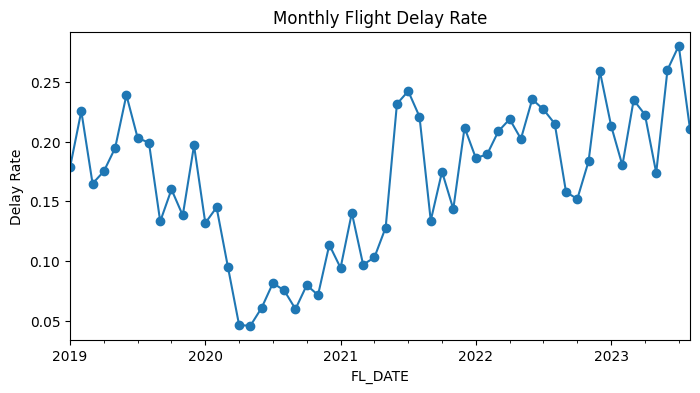

In [ ]:
# Compute monthly average delay rate
monthly = df.set_index("FL_DATE").resample("M")["DELAYED"].mean()

# Plot monthly delay rate
monthly.plot(marker="o", figsize=(8,4))
plt.title("Monthly Flight Delay Rate")
plt.ylabel("Delay Rate")
plt.show()


>> ARIMA model

In [ ]:
# Prepare time series for ARIMA model
ts = monthly.asfreq("M").fillna(method="ffill")

# Fit ARIMA(1,1,1) model
model = sm.tsa.ARIMA(ts, order=(1,1,1))
res = model.fit()

# Display model summary
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                DELAYED   No. Observations:                   56
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  99.835
Date:                Tue, 25 Nov 2025   AIC                           -193.669
Time:                        09:25:25   BIC                           -187.647
Sample:                    01-31-2019   HQIC                          -191.341
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3265      0.330      0.989      0.323      -0.320       0.973
ma.L1         -0.6756      0.248     -2.722      0.006      -1.162      -0.189
sigma2         0.0015      0.000      5.096      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.96   Prob(JB):                         0.73
Heteroskedasticity (H):               1.01   Skew:                             0.26
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

>> Forecast

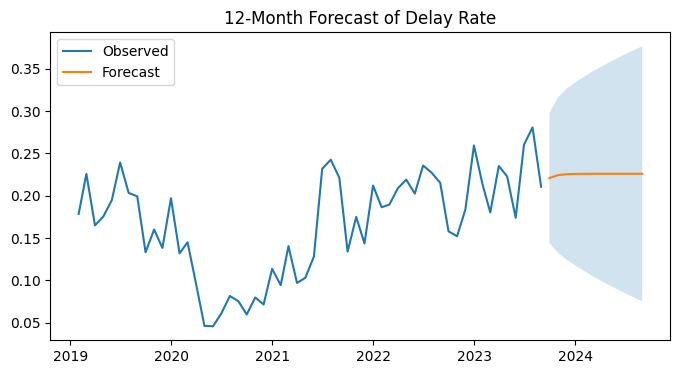

In [ ]:
# Forecast future delay rate
forecast = res.get_forecast(steps=12)
mean = forecast.predicted_mean
conf = forecast.conf_int()

# Plot observed vs forecasted delay rate
plt.figure(figsize=(8,4))
plt.plot(ts.index, ts, label="Observed")
plt.plot(mean.index, mean, label="Forecast")
plt.fill_between(conf.index, conf.iloc[:,0], conf.iloc[:,1], alpha=0.2)

plt.title("12-Month Forecast of Delay Rate")
plt.legend()
plt.show()


**9. Conclusion**

This analysis provides a comprehensive view of flight delays using machine learning, clustering, and time-series forecasting. The Random Forest classifier effectively predicts delays using operational variables, while anomaly detection highlights critical irregularities. Clustering reveals distinct delay behavior patterns, and ARIMA forecasting projects future delay trends.

Together, these insights support operational decision-making and provide airlines with tools to enhance scheduling reliability, resource allocation, and overall service performance.